## Import Dependencies

In [1]:
from sklearn.datasets import fetch_20newsgroups

## Generate Training Data

In [2]:
categories_train = ['comp.graphics', 'comp.sys.ibm.pc.hardware',
              'comp.sys.mac.hardware', 'comp.windows.x']
train_data = fetch_20newsgroups(subset='train', categories=categories_train)['data']

`train_data` has queries related only to computers. Your task is train a model to reject queries outside this domain. The classifier must output 1 for queries in domain and -1 for queries which are out of domain

## Your solution from here. Good Luck !

In [3]:
len(train_data)

2345

In [80]:
import pickle
import random
from sklearn.metrics import fbeta_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
#pickle.dump(train_data,open('train_data','wb'))

In [256]:
other=fetch_20newsgroups(subset='train',categories=['alt.atheism', 'rec.sport.baseball','rec.autos','misc.forsale','sci.med'])['data']
others=random.sample(other,200)
#pickle.dump(others,open('outliers','wb'))

In [141]:
test=fetch_20newsgroups(subset='train',categories=['comp.os.ms-windows.misc'])['data']
#pickle.dump(test,open('test','wb'))

In [257]:
len(others)

200

In [14]:
import numpy as np

In [8]:
from nltk.corpus import names
from nltk.stem import WordNetLemmatizer

In [9]:
def letter_only(string):
    return string.isalpha()
def clean_data(text):
    cleaned=[]
    all_names=set(names.words())
    lemmatizer=WordNetLemmatizer()
    for item in text:
        cleaned.append(' '.join([lemmatizer.lemmatize(word.lower()) for word in item.split() if letter_only(word) and word not in all_names]))
    return cleaned

In [207]:
train_cleaned=clean_data(train_data)
test_cleaned=clean_data(test)
outliers_cleaned=clean_data(others)

In [11]:
import re
from nltk.tokenize import RegexpTokenizer
import nltk

In [12]:
def preprocess(text):
    preprocessed=[]
    for item in text:
        tokenizer = RegexpTokenizer(r'\w+') 
        tokenized = tokenizer.tokenize(item)
        tagged=nltk.pos_tag(tokenized)
        nouns=[]
        for tag in tagged:
        #words with POS tags beginning with N are nouns
            if re.search(r'^N',tag[1]):
                nouns.append(tag[0])
        preprocessed.append(nouns)
    preprocessed=[' '.join(article) for article in preprocessed]
    return preprocessed

In [208]:
train_pp=preprocess(train_cleaned)
test_pp=preprocess(test_cleaned)
outlier_pp=preprocess(outliers_cleaned)

In [ ]:
train_pp[0]

In [ ]:
len(train_cleaned)

In [ ]:
train_cleaned[0]

In [ ]:
train_data[0]

In [209]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
vectorizer = TfidfVectorizer(stop_words='english')#,max_features=100)
trainv=vectorizer.fit_transform(train_pp)
svd=TruncatedSVD(n_components=120)
svd.fit(trainv)
trainv=svd.transform(trainv)
outliersv=vectorizer.transform(outlier_pp)
outliersv=svd.transform(outliersv)
testv=vectorizer.transform(test_pp)
testv=svd.transform(testv)

In [210]:
y_train=list(np.zeros(len(train_pp)))
y_test=list(np.zeros(len(test_pp)))
y_outliers=list(np.ones(len(outlier_pp)))

In [211]:
from sklearn.model_selection import train_test_split
trainx, normal_testx, trainy, normal_testy = train_test_split(trainv, y_train, test_size=.2, random_state=42)
normal_valx, normal_testx, normal_valy, normal_testy = train_test_split(normal_testx, normal_testy, test_size=.5, random_state=42)
abnormal_valx, abnormal_testx, abnormal_valy, abnormal_testy = train_test_split(outliersv, y_outliers, test_size=.5, random_state=42)

In [212]:
#np.concatenate([normal_valx.todense(),abnormal_valx.todense()]).shape
np.concatenate([normal_valx,abnormal_valx]).shape

(334, 120)

matrix([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ..., 
        [ 0.42495086,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.36025579],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.39562324,  0.        , ...,  0.        ,
          0.        ,  0.        ]])

In [213]:
#val_x=np.concatenate((normal_valx.todense(),abnormal_valx.todense()),axis=0)
val_x=np.concatenate((normal_valx,abnormal_valx),axis=0)
val_y=np.concatenate((normal_valy,abnormal_valy),axis=0)
test_x=np.concatenate((normal_testx,abnormal_testx),axis=0)
#test_x=np.concatenate((normal_testx.todense(),abnormal_testx.todense()),axis=0)
test_y=np.concatenate((normal_testy,abnormal_testy),axis=0)

In [214]:
trainx.shape

(1876, 120)

In [215]:
print('Train shape: ', trainx.shape)
print('Proportion of anomaly in training set: %.2f\n' % np.mean(trainy))
print('Valid shape: ', val_x.shape)
print('Proportion of anomaly in validation set: %.2f\n' % np.mean(val_y))
print('Test shape:, ', test_x.shape)
print('Proportion of anomaly in test set: %.2f\n' % np.mean(test_y))

Train shape:  (1876, 120)
Proportion of anomaly in training set: 0.00

Valid shape:  (334, 120)
Proportion of anomaly in validation set: 0.30

Test shape:,  (335, 120)
Proportion of anomaly in test set: 0.30



In [216]:
trainv.shape

(2345, 120)

In [217]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=3, n_init=4, random_state=42)
#gmm.fit(trainx.todense())
gmm.fit(trainx)


GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=3, n_init=4, precisions_init=None,
        random_state=42, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [218]:
tresholds = np.linspace(-100, 400, 100)
y_scores = gmm.score_samples(val_x)
scores = []
for treshold in tresholds:
    y_hat = (y_scores < treshold).astype(int)
    scores.append([recall_score(y_pred=y_hat, y_true=val_y),
                 precision_score(y_pred=y_hat, y_true=val_y),
                 fbeta_score(y_pred=y_hat, y_true=val_y, beta=1)])

scores = np.array(scores)
print(scores[:, 2].max(), scores[:, 2].argmax())

/home/aman/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/aman/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


0.460829493088 77


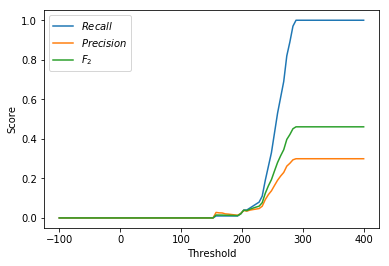

In [219]:
plt.plot(tresholds, scores[:, 0], label='$Recall$')
plt.plot(tresholds, scores[:, 1], label='$Precision$')
plt.plot(tresholds, scores[:, 2], label='$F_2$')
plt.ylabel('Score')
plt.xlabel('Threshold')
plt.legend(loc='best')
plt.show()

In [255]:
final_tresh = tresholds[scores[:, 2].argmax()]
y_hat_test = (gmm.score_samples(test_x) < final_tresh).astype(int)

print('Final threshold: %f' % final_tresh)
print('Test Recall Score: %.3f' % recall_score(y_pred=y_hat_test, y_true=test_y))
print('Test Precision Score: %.3f' % precision_score(y_pred=y_hat_test, y_true=test_y))
print('Test F2 Score: %.3f' % fbeta_score(y_pred=y_hat_test, y_true=test_y, beta=1))

#cnf_matrix = confusion_matrix(test_y, y_hat_test)
#plot_confusion_matrix(cnf_matrix, classes=['Normal','Anormal'], title='Confusion matrix')

Final threshold: 288.888889
Test Recall Score: 0.010
Test Precision Score: 0.333
Test F2 Score: 0.019


In [240]:
(gmm.score_samples(test_x).max()<).astype(int)

-93.586328743946282

In [157]:
from sklearn.ensemble import IsolationForest
model = IsolationForest(random_state=42, n_jobs=-1, max_samples=trainx.todense().shape[0], bootstrap=True, n_estimators=10)
model.fit(trainx.todense())
#print(model.decision_function(valid[valid['Class'] == 0].drop('Class', axis=1).values).mean())
#print(model.decision_function(valid[valid['Class'] == 1].drop('Class', axis=1).values).mean())

IsolationForest(bootstrap=True, contamination=0.1, max_features=1.0,
        max_samples=1172, n_estimators=10, n_jobs=-1, random_state=42,
        verbose=0)

In [158]:
tresholds = np.linspace(0, .5, 200)
y_scores = model.decision_function(val_x)
scores = []
for treshold in tresholds:
    y_hat = (y_scores < treshold).astype(int)
    scores.append([recall_score(y_pred=y_hat, y_true=val_y),
                 precision_score(y_pred=y_hat, y_true=val_y),
                 fbeta_score(y_pred=y_hat, y_true=val_y, beta=2)])

scores = np.array(scores)
print(scores[:, 2].max(), scores[:, 2].argmax())

/home/aman/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/aman/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


0.68082788671 78


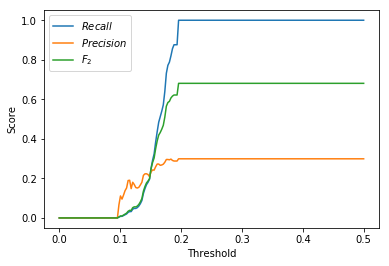

In [159]:
plt.plot(tresholds, scores[:, 0], label='$Recall$')
plt.plot(tresholds, scores[:, 1], label='$Precision$')
plt.plot(tresholds, scores[:, 2], label='$F_2$')
plt.ylabel('Score')
plt.xlabel('Threshold')
plt.legend(loc='best')
plt.show()

In [160]:
final_tresh = tresholds[scores[:, 2].argmax()]
y_hat_test = (model.decision_function(test_x) < final_tresh).astype(int)

print('Final threshold: %f' % final_tresh)
print('Test Recall Score: %.3f' % recall_score(y_pred=y_hat_test, y_true=test_y))
print('Test Precision Score: %.3f' % precision_score(y_pred=y_hat_test, y_true=test_y))
print('Test F2 Score: %.3f' % fbeta_score(y_pred=y_hat_test, y_true=test_y, beta=2))


Final threshold: 0.195980
Test Recall Score: 1.000
Test Precision Score: 0.299
Test F2 Score: 0.680


In [ ]:
outliersv=vectorizer.transform(preprocess(outliers_cleaned))
#outliersv=svd.transform(outliersv)
testv=vectorizer.transform(preprocess(test_cleaned))
#testv=svd.transform(testv)

In [ ]:
from sklearn import svm
clf = svm.OneClassSVM(nu=0.17, kernel="rbf", gamma=1.2)
clf.fit(trainv)
y_pred_train = clf.predict(trainv)
y_pred_test = clf.predict(testv)
y_pred_outliers = clf.predict(outliersv)
n_error_train = y_pred_train[y_pred_train == -1].size
n_error_test = y_pred_test[y_pred_test == -1].size
n_error_outliers = y_pred_outliers[y_pred_outliers == 1].size

In [ ]:
print("train {}/{}={}".format(n_error_train,len(train_data),n_error_train/len(train_data)))

print("test {}/{}={}".format(n_error_test,len(test),n_error_test/len(test)))

print("outliers {}/{}={}".format(n_error_outliers,len(others),n_error_outliers/len(others)))

In [ ]:
from sklearn.ensemble import IsolationForest
clf = IsolationForest(max_samples=100)
clf.fit(trainv)
y_pred_train = clf.predict(trainv)
y_pred_test = clf.predict(testv)
y_pred_outliers = clf.predict(outliersv)
n_error_train = y_pred_train[y_pred_train == -1].size
n_error_test = y_pred_test[y_pred_test == -1].size
n_error_outliers = y_pred_outliers[y_pred_outliers == 1].size
print("train {}/{}={}".format(n_error_train,len(train_data),n_error_train/len(train_data)))

print("test {}/{}={}".format(n_error_test,len(test),n_error_test/len(test)))

print("outliers {}/{}={}".format(n_error_outliers,len(others),n_error_outliers/len(others)))

In [ ]:
others[10]

In [ ]:
from sklearn.covariance import EllipticEnvelope
clf = EllipticEnvelope()
clf.fit(trainv)
y_pred_train = clf.predict(trainv)
y_pred_test = clf.predict(testv)
y_pred_outliers = clf.predict(outliersv)
n_error_train = y_pred_train[y_pred_train == -1].size
n_error_test = y_pred_test[y_pred_test == -1].size
n_error_outliers = y_pred_outliers[y_pred_outliers == 1].size
print("train {}/{}={}".format(n_error_train,len(train_data),n_error_train/len(train_data)))

print("test {}/{}={}".format(n_error_test,len(test),n_error_test/len(test)))

print("outliers {}/{}={}".format(n_error_outliers,len(others),n_error_outliers/len(others)))

In [ ]:
from sklearn.n_neighbors import LocalOutlierFactor
clf = LocalOutlierFactor(n_neighbors=20)
y_pred_train = clf.fit(trainv)
y_pred_test = clf.predict(testv)
y_pred_outliers = clf.predict(outliersv)
n_error_train = y_pred_train[y_pred_train == -1].size
n_error_test = y_pred_test[y_pred_test == -1].size
n_error_outliers = y_pred_outliers[y_pred_outliers == 1].size
print("train {}/{}={}".format(n_error_train,len(train_data),n_error_train/len(train_data)))

print("test {}/{}={}".format(n_error_test,len(test),n_error_test/len(test)))

print("outliers {}/{}={}".format(n_error_outliers,len(others),n_error_outliers/len(others)))
